# Student project: Density of states for the valance band silicon

Author: Michael Pusterhofer

The valance band can be described using two parabolas. One for heavy holes and one for light holes.
The dispersion relation for those bands are listed below:

$\begin{equation}
E_{v,lh}=-\frac{\hbar^2}{2m_{e}}\left(4.1k^2-\sqrt{1.21k^4+4.1(k_x^2k_y^2+k_x^2k_z^2+k_y^2k_z^2)}\right)
\end{equation}$

$\begin{equation}
E_{v,hh}=-\frac{\hbar^2}{2m_{e}}\left(4.1k^2+\sqrt{1.21k^4+4.1(k_x^2k_y^2+k_x^2k_z^2+k_y^2k_z^2)}\right)
\end{equation}$

The split-off band can be calculated by:

$\begin{equation}
E_{v,so}=-E_{so}-\frac{\hbar^2k^2}{2m_{so}}.
\end{equation}$

For silicon $E_{so}$ is $0.035 eV$ and $m_{so}$ is $0.24 m_e$. Those values are as well as the equations are taken from http://lampx.tugraz.at/~hadley/memm/materials/silicon/silicon.php .

One can notice that the dispersion relation is symmetric in x, y, z. This allows to calculate only 1/8 of the k space(positive k values)

By calculating the energy on a cubic grid we can determine the Density of states by counting the energies. This is done by binning using the numpy.histogram method.

Because we calculate only 1/8 of the k space and our k-point spacing is different the density of states we have to multiply our result by 8 and divide by the volume of k-state as well as the bin size used in numpy.histogram.

## Calculate DOS(E) for light and heavy holes + split-off band
The calculation takes the positive octant of k-space and calculates the corresponding energies. This is done in sets of 10000 points, which are binned(600 bins between 0 and -0.06 eV) to save memory. In total $500^3$ points are calculated. 

In [1]:
# initializing python libraries
%pylab
%matplotlib inline
# import constants
from scipy.constants import hbar, m_e, eV, angstrom
# import iterator helper functions
import itertools as it
# import just in time compiler for optimization
from numba import jit

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
## set constants
# split-off band mass
m_so = 0.24*m_e
# split off band energy
energy_so = 0.035*eV
# maximum k value for one axis (a_Si = 5.43A)
kmax = pi/(5.43*angstrom)/4
# number of k points for one axis (0-kmax)
nofkpoints = 500
# bins for the density of states (see numpy.histogram)
bins = linspace(-0.06,0,600)

## calculate k-values
# calculate k²-values for one axis
k2range = linspace(0,kmax,nofkpoints)**2
# define iterator for k-values in the positive octant
it_k = it.product(k2range,repeat=3)

## create store for frequency values (see numpy.histogram)
freq = zeros(bins.size-1)

## define functions

@jit
def get_k2(k2x,k2y,k2z):
    """calculate k2 from k2x,k2y,k2z"""
    return k2x+k2y+k2z

@jit
def root_part(k2,k2x,k2y,k2z):
    """calculate the root part of the dispersion relation for heavy/light holes"""
    return sqrt(1.21*k2**2+4.1*(k2x*k2y+k2x*k2z+k2y+k2z)) 

@jit
def get_heavy(part1,part2):
    """calculate the dispersion relation for heavy holes"""
    return -1/eV*hbar**2/(2*m_e)*(4.1*part1+part2)
    
@jit
def get_light(part1,part2):
    """calculate the dispersion relation for light holes"""
    return -1/eV*hbar**2/(2*m_e)*(4.1*part1-part2)

@jit
def get_freq_hist(x,bins):
    """calculate the frequencies using the values x and the bin-edges bins"""
    freq,_ = histogram(x,bins=bins)
    return freq

@jit
def get_so(k2):
    """calculate the dispersion relation for the split-off band"""
    return (-energy_so-hbar**2*k2/(2*m_so))/eV

@jit
def get_freq_for_n(it_k,n):
    """calculate the frequencies using n values of the iterator it_k"""
    energy = empty([n,2])
    energy.fill(np.nan)
    count = 0
    
    # calculate reusable part of the dispersion relation
    for i,(k2x,k2y,k2z) in enumerate(it_k):
        k2 = get_k2(k2x,k2y,k2z)
        # calculate k²
        energy[i,0] = k2 
        # calculate the root them
        energy[i,1] = root_part(k2,k2x,k2y,k2z)
        count = i
        if i >= n-1:
            break; 
    # calculate the energies for heavy/light holes and the split-off band        
    heavy = get_heavy(energy[:,0],energy[:,1])
    light = get_light(energy[:,0],energy[:,1])
    so = get_so(energy[:,0]) 
     
    # check if iterator had enough values
    if count == n:
        h_freq = get_freq_hist(heavy,bins)
        l_freq = get_freq_hist(light,bins)
        so_freq = get_freq_hist(so,bins)
    # remove NaNs from the calculation
    else:
        h_freq = get_freq_hist(heavy[~isnan(heavy)],bins)
        l_freq = get_freq_hist(light[~isnan(light)],bins)
        so_freq = get_freq_hist(so[~isnan(so)],bins)
        
    # return sum of all band frequencies
    return h_freq + l_freq + so_freq


## calculate the DOS
count = 0;
while(nofkpoints**3 > count):
    # define chunk size
    n = 10000
    nfreq = get_freq_for_n(it_k,n)
    freq += nfreq    
    count += n
    print("{:3.0f}%".format(100*count/nofkpoints**3),end="\r")

# get size of one bin
dE = bins[1]-bins[0]
# get box length of one k-state
L = 2*pi / (sqrt(k2range[1])-sqrt(k2range[0]))
# multiply by 8, because we used only an octant in k-space
# divide by bin size
# divide by k-state volume
freq = 8 * freq / dE / L**3



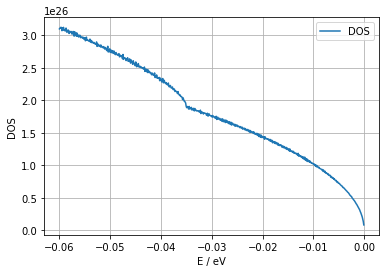

In [3]:
## plot DOS
figure()
plot(bins[:-1],freq,label="DOS")
grid()
ylabel("DOS")
xlabel("E / eV")
legend();

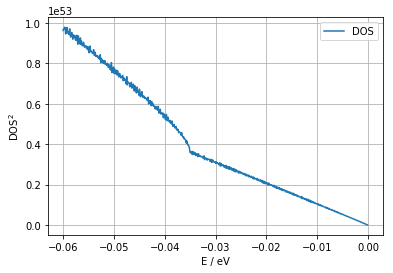

In [4]:
## plot DOS squared
figure()
plot(bins[:-1],freq**2,label="DOS")
grid()
ylabel("DOS$^2$")
xlabel("E / eV")
legend();

In [5]:
## create a DataFrame and export it as csv file
import pandas as pd
df = pd.DataFrame(data = {"freq":freq,"bins":bins[:-1]})
print(df.tail())
df.to_csv("DOS_Si.csv")

         bins          freq
594 -0.000501  2.290477e+25
595 -0.000401  2.050530e+25
596 -0.000301  1.749420e+25
597 -0.000200  1.384010e+25
598 -0.000100  8.405998e+24
